# Base Model

- Train: 75Agree_train
- Test: 75Agree_test

### Step 1: Prepate the data to feed the model

In [1]:
import pandas as pd

# load the training and test datasets
df_train = pd.read_csv('data/75Agree_train.csv')
df_test = pd.read_csv('data/75Agree_test.csv')

# label encoders
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}

# label encoding
df_train["label"] = df_train["label"].map(label2id)
df_test["label"] = df_test["label"].map(label2id)

# balance the training set: undersample to minority class
df_train = df_train.groupby("label").apply(lambda x: x.sample(df_train["label"].value_counts().min())).reset_index(drop=True)
df_train.value_counts("label")

/var/folders/sz/96b_h5gn3y33k0c7jsvrstmm0000gn/T/ipykernel_14368/1846001758.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby("label").apply(lambda x: x.sample(df_train["label"].value_counts().min())).reset_index(drop=True)


label
0    336
1    336
2    336
Name: count, dtype: int64

### Step 2: The model

In [2]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import numpy as np

# tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length", max_length=128)

# dataset preparation for huggingface transformers
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# the model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id)

training_args = TrainingArguments(
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="steps",
    eval_steps=25,
    logging_strategy="steps",
    logging_steps=25,
    report_to=None,
    dataloader_pin_memory=False,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_total_limit=1,
    save_steps=500,
    output_dir="./results",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

# train the model
trainer.train()

/opt/anaconda3/envs/CAA02/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 691/691 [00:00<00:00, 3152.26 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/sz/96b_h5gn3y33k0c7jsvrstmm0000gn/T/ipykernel_14368/199123364.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
25,1.029700,0.929534
50,0.799100,0.721338
75,0.508800,0.420310
100,0.348900,0.329533
125,0.303400,0.275432
150,0.182200,0.282266
175,0.154600,0.255216
200,0.105000,0.311728
225,0.106000,0.300315
250,0.081800,0.274428


TrainOutput(global_step=252, training_loss=0.3595364353072549, metrics={'train_runtime': 466.0653, 'train_samples_per_second': 8.651, 'train_steps_per_second': 0.541, 'total_flos': 265218325069824.0, 'train_loss': 0.3595364353072549, 'epoch': 4.0})

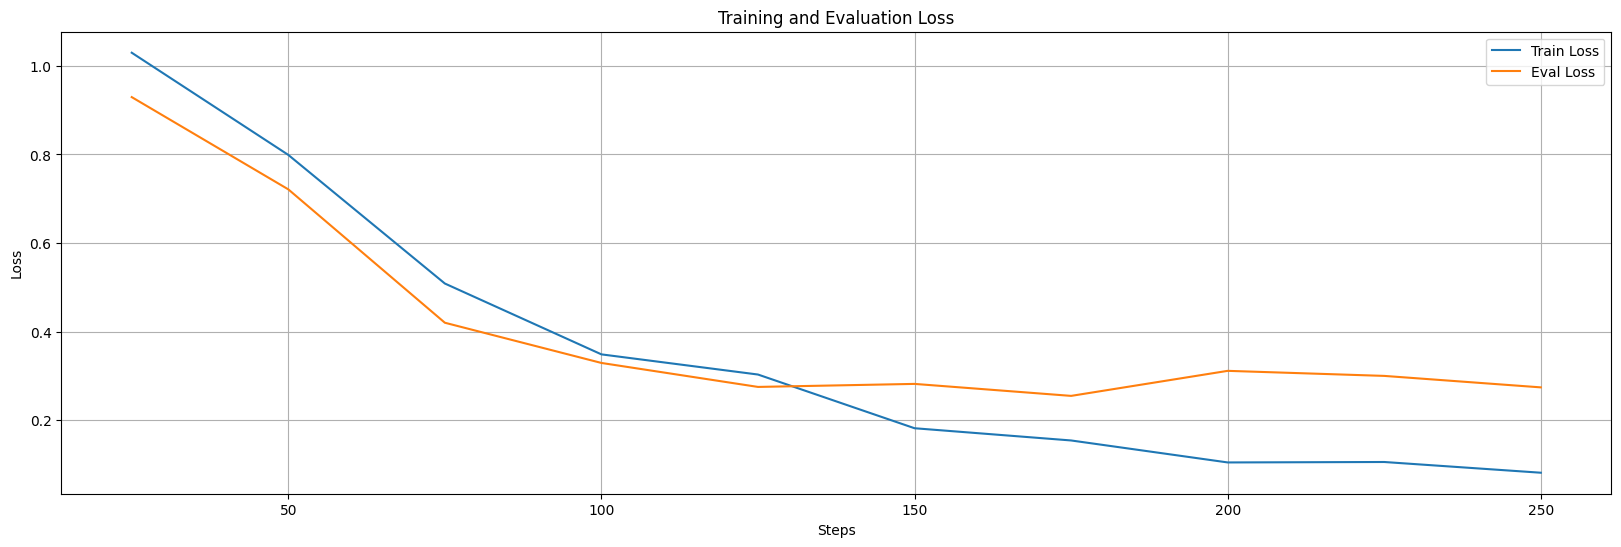

In [3]:
import matplotlib.pyplot as plt

# get training and evaluation loss history
log_history = trainer.state.log_history
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_loss = [x["eval_loss"] for x in log_history if "eval_loss" in x]
eval_steps = [x["step"] for x in log_history if "eval_loss" in x]
train_steps = [x["step"] for x in log_history if "loss" in x]

plt.figure(figsize=(20, 6))
plt.plot(train_steps, train_loss, label="Train Loss")
plt.plot(eval_steps, eval_loss, label="Eval Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

### Step 3: Evaluate the model


=== Classification Report (Train) ===
              precision    recall  f1-score   support

    negative       0.97      1.00      0.99       336
     neutral       1.00      0.98      0.99       336
    positive       0.99      0.98      0.99       336

    accuracy                           0.99      1008
   macro avg       0.99      0.99      0.99      1008
weighted avg       0.99      0.99      0.99      1008



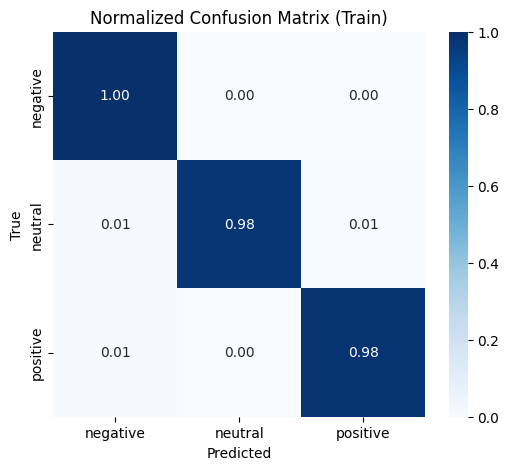


=== Classification Report (Test) ===
              precision    recall  f1-score   support

    negative       0.79      0.96      0.87        84
     neutral       0.97      0.89      0.93       429
    positive       0.81      0.89      0.84       178

    accuracy                           0.90       691
   macro avg       0.86      0.91      0.88       691
weighted avg       0.91      0.90      0.90       691



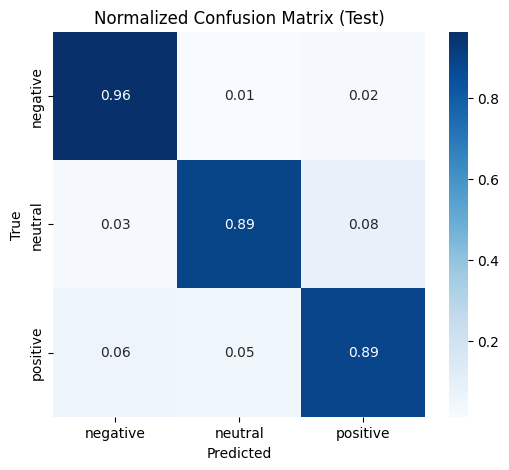

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_dataset(dataset, split_name):
    output = trainer.predict(dataset)
    preds = np.argmax(output.predictions, axis=1)
    y_true = output.label_ids

    print(f"\n=== Classification Report ({split_name}) ===")
    print(classification_report(y_true, preds, target_names=["negative", "neutral", "positive"]))

    cm = confusion_matrix(y_true, preds, normalize='true')
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["negative", "neutral", "positive"],
                yticklabels=["negative", "neutral", "positive"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Normalized Confusion Matrix ({split_name})")
    plt.show()

# evaluate the model on the training and test datasets
evaluate_dataset(train_dataset, "Train")
evaluate_dataset(test_dataset, "Test")